In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.utils import dense_to_sparse
import numpy as np

# Load the labeled and unlabeled data
labeled_data = pd.read_csv('3k_labeled_extracted.csv')
unlabeled_data = pd.read_csv('6k_unlabeled_extracted.csv')

# Drop the 'text_' column as it's not required
labeled_data = labeled_data.drop(columns=['text_'])
unlabeled_data = unlabeled_data.drop(columns=['text_'])

# Separate features and labels
X_labeled = labeled_data.drop(columns=['label']).values
y_labeled = labeled_data['label'].values
X_unlabeled = unlabeled_data.values

# Normalize the features using Standard Scaler
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# Convert to torch tensors
X_labeled_tensor = torch.tensor(X_labeled_scaled, dtype=torch.float)
y_labeled_tensor = torch.tensor(y_labeled, dtype=torch.long)
X_unlabeled_tensor = torch.tensor(X_unlabeled_scaled, dtype=torch.float)

# Compute cosine similarity between all reviews
similarity_matrix = cosine_similarity(np.vstack([X_labeled_scaled, X_unlabeled_scaled]))

# Create an adjacency matrix where high similarity is considered an edge
threshold = 0.7  # Adjust threshold for graph sparsity
adjacency_matrix = (similarity_matrix > threshold).astype(int)

# Convert adjacency matrix to edge index format for PyTorch Geometric
edge_index = dense_to_sparse(torch.tensor(adjacency_matrix, dtype=torch.float))[0]

# Prepare PyTorch Geometric Data
features = torch.cat([X_labeled_tensor, X_unlabeled_tensor], dim=0)
data = Data(x=features, edge_index=edge_index)

# Saving the processed data
torch.save({
    'features': features,
    'edge_index': edge_index,
    'labels': y_labeled_tensor
}, 'processed_graph_data.pt')
print("Processed data saved to 'processed_graph_data.pt'.")


Processed data saved to 'processed_graph_data.pt'.


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Encoder: learn low-dimensional embeddings
        encoded = F.relu(self.encoder(x, edge_index))
        # Decoder: reconstruct from embeddings
        decoded = self.decoder(encoded, edge_index)
        return decoded, encoded

# Model parameters
in_channels = features.size(1)
hidden_channels = 64
out_channels = in_channels

# Initialize the GAE model
gae_model = GraphAutoencoder(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01, weight_decay=5e-4)

# Saving the model state
torch.save(gae_model.state_dict(), 'graph_autoencoder_model.pt')
print("Model state saved to 'graph_autoencoder_model.pt'.")

Model state saved to 'graph_autoencoder_model.pt'.


In [10]:
def train_gae(data, epochs=1):
    gae_model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        decoded, encoded = gae_model(data.x, data.edge_index)
        
        # Reconstruction loss (MSE between original and decoded features)
        loss = F.mse_loss(decoded, data.x)
        
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Save the model state after training
    torch.save(gae_model.state_dict(), 'graph_autoencoder_model_trained.pt')
    print("Trained model state saved to 'graph_autoencoder_model_trained.pt'.")

# Train the Graph Autoencoder
train_gae(data)

Epoch 0, Loss: 2.291130304336548
Trained model state saved to 'graph_autoencoder_model_trained.pt'.


GAE embeddings saved to 'gae_encoded_features.npy'.
[LightGBM] [Info] Number of positive: 1484, number of negative: 1516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494667 -> initscore=-0.021334
[LightGBM] [Info] Start training from score -0.021334

Evaluating LightGBM Classifier...
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1516
           1       0.99      0.98      0.99      1484

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 98.77%


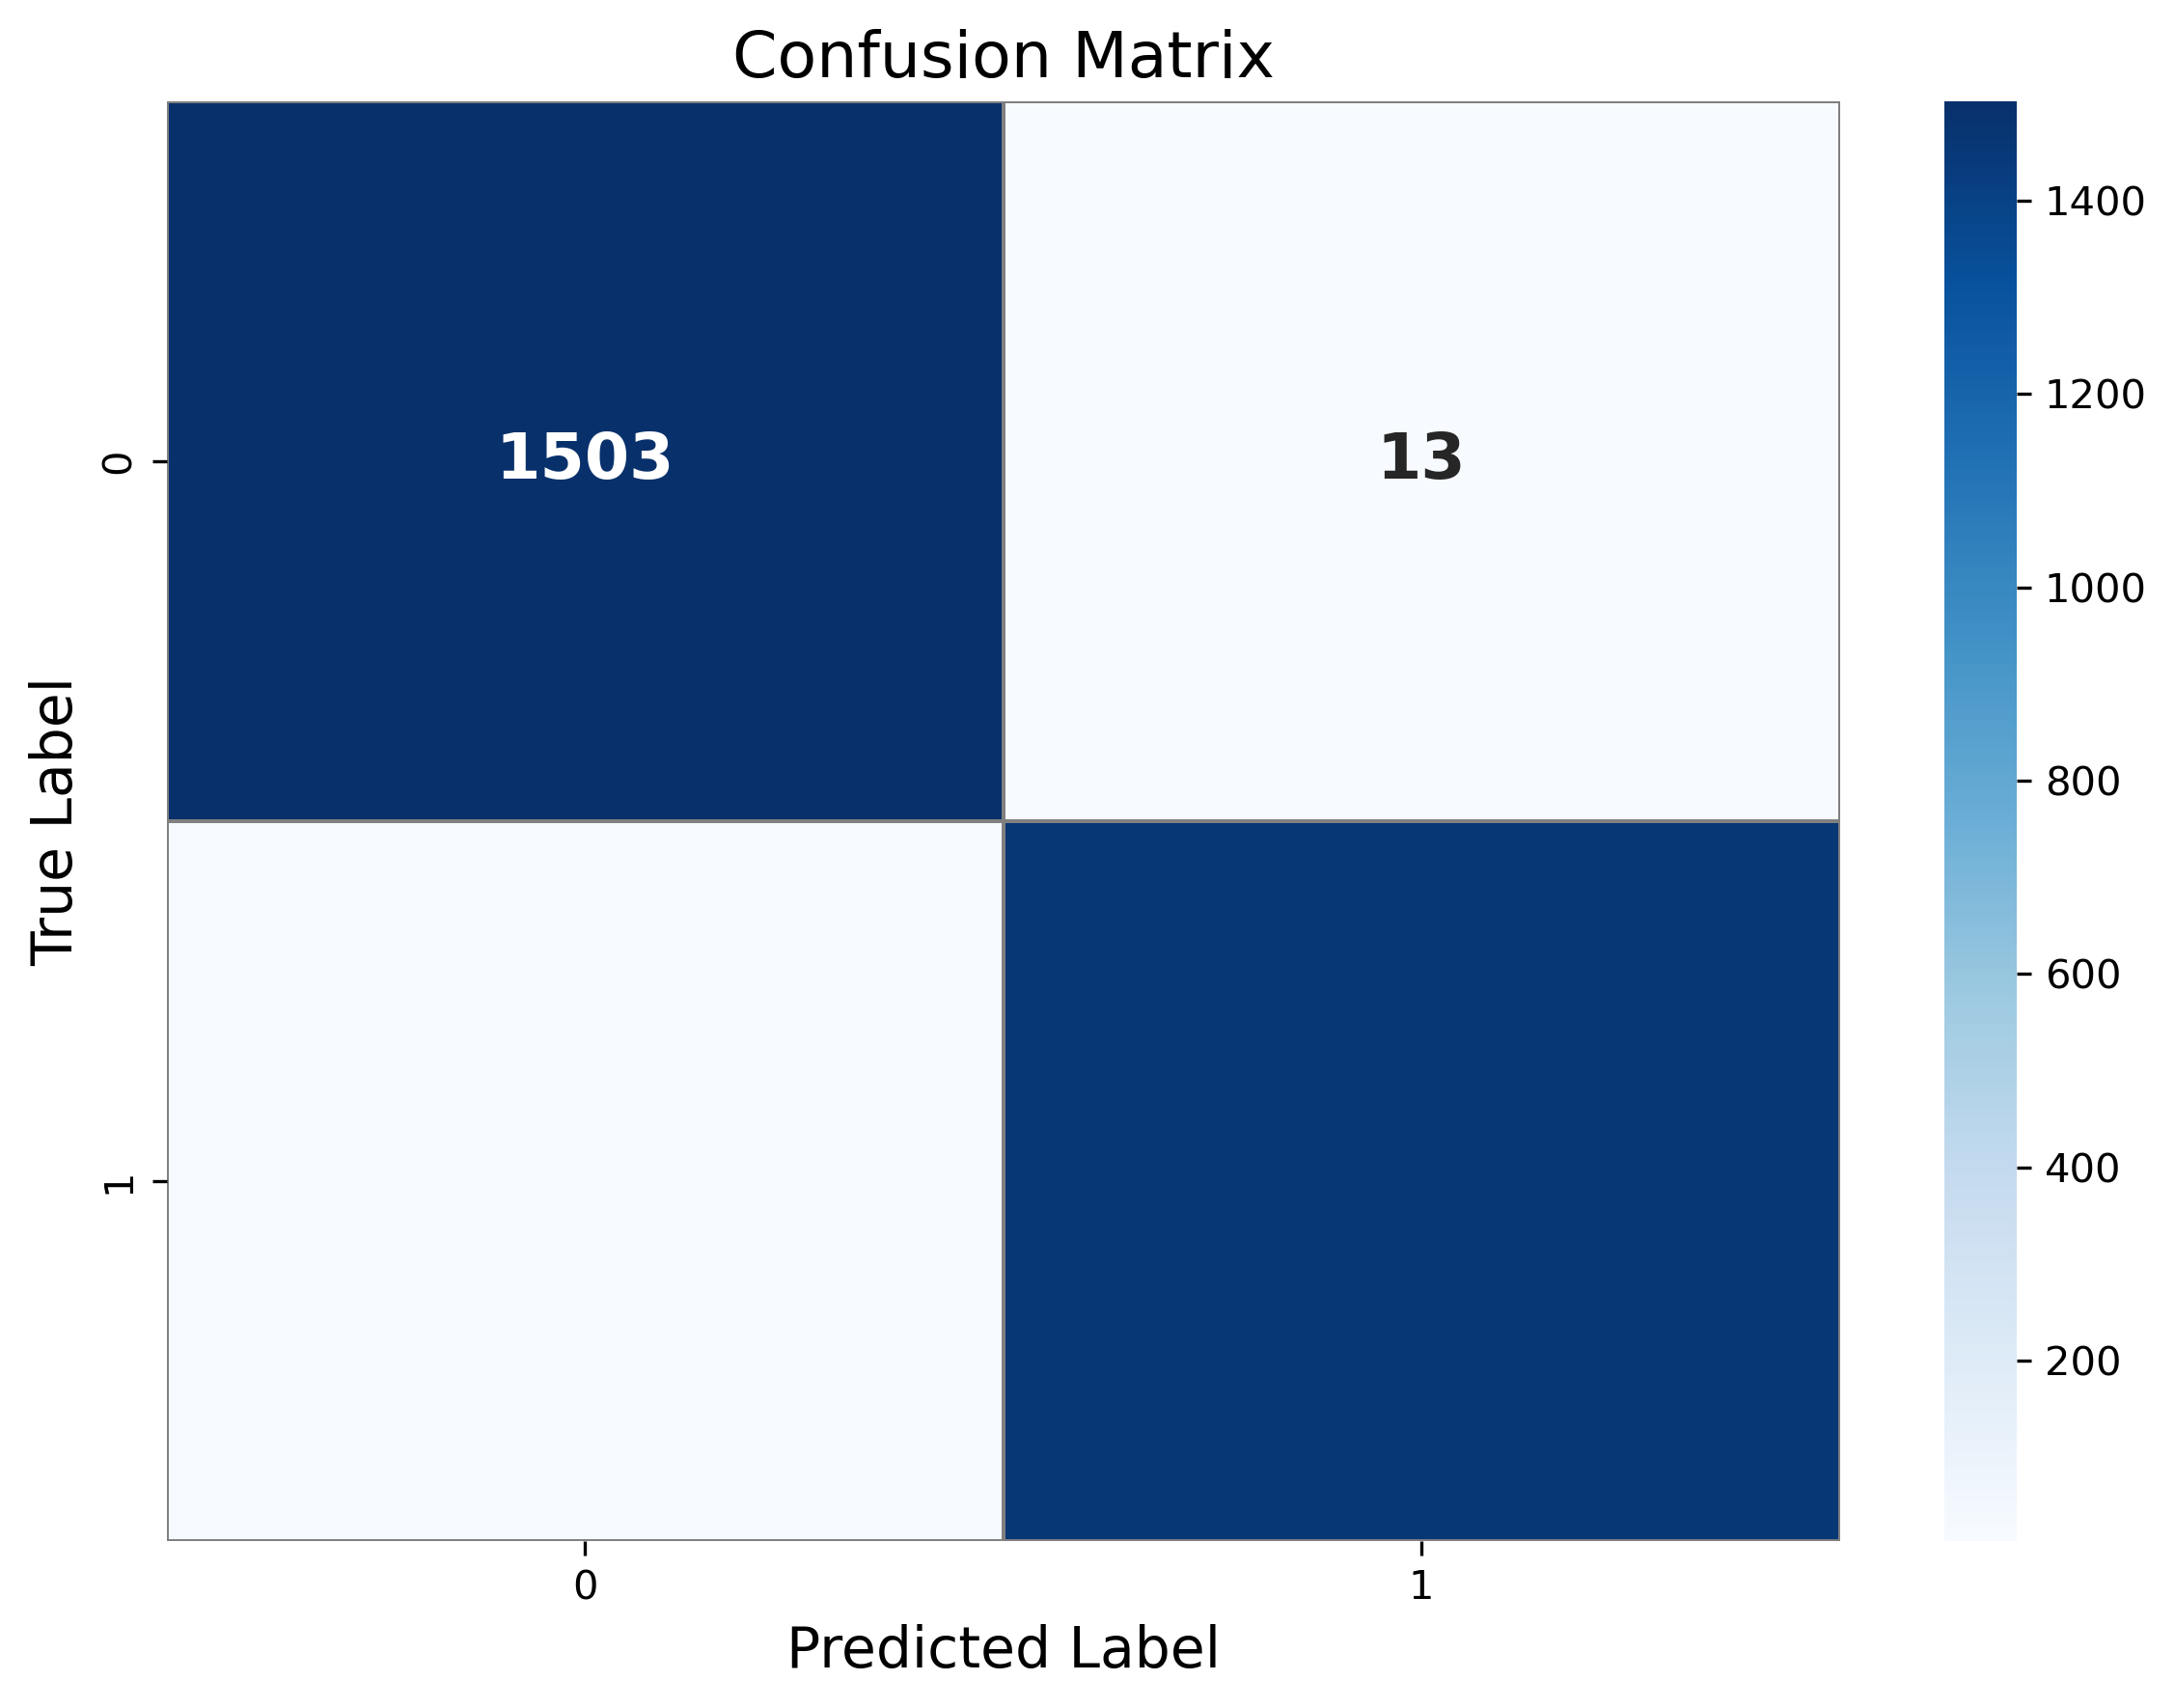

Unlabeled data with predicted labels saved to 'predictions_lightgbm_unlabeled_data.csv'.

Head of the new predictions:
   rating  Positive Score  Negative Score  Neutral Score  Compound Score  \
0     3.0           0.000           0.000          1.000          0.0000   
1     1.0           0.073           0.253          0.674         -0.8685   
2     5.0           0.598           0.000          0.402          0.9246   
3     1.0           0.158           0.094          0.747          0.7500   
4     5.0           0.203           0.054          0.743          0.9287   

   Review Length  Noun Count  Verb Count  Adjective Count  Joy Score  \
0              1           1           0                0      0.000   
1             42          12           9                5      0.073   
2             14           5           2                2      0.598   
3            140          45          27               11      0.158   
4             79          22          19                5      0

In [22]:
import pandas as pd
import numpy as np
import torch
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Custom function to extract embeddings
def extract_embeddings(model: torch.nn.Module, data: Data) -> np.ndarray:
    """Extract embeddings from the graph autoencoder model."""
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        _, encoded_features = model(data.x, data.edge_index)
    return encoded_features.numpy()


# Custom function to evaluate a classifier
def evaluate_classifier(classifier, X_train: np.ndarray, y_train: np.ndarray) -> None:
    """Evaluate the trained model and print classification report."""
    y_pred = classifier.predict(X_train)  # Predict on the labeled training data
    report = classification_report(y_train, y_pred, output_dict=True)
    accuracy = report['accuracy'] * 100  # Convert to percentage
    print("Classification Report:\n")
    print(classification_report(y_train, y_pred))
    print(f"Accuracy: {accuracy:.2f}%")
    plot_confusion_matrix(y_train, y_pred)

    return accuracy, y_pred


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred) -> None:
    """Plot the confusion matrix with a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6), dpi=300)  # High-resolution figure
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
                annot_kws={"size": 16, "weight": "bold"},  # Bold text
                linewidths=0.5, linecolor='gray')  # Add lines between boxes for better readability
    
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(classifier, X_train: np.ndarray, y_train: np.ndarray) -> None:
    """Plot precision-recall curve."""
    y_scores = classifier.predict_proba(X_train)[:, 1]  # Get the predicted probabilities
    precision, recall, _ = precision_recall_curve(y_train, y_scores)

    plt.figure(figsize=(8, 6), dpi=300)  # High-resolution figure
    plt.plot(recall, precision, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.tight_layout()
    plt.show()

# Function to predict unlabeled data
def predict_unlabeled_data(classifier, encoded_features: np.ndarray, num_labeled: int) -> np.ndarray:
    """Predict labels for unlabeled data using the trained classifier."""
    X_unlabeled_features = encoded_features[num_labeled:]  # Get unlabeled features
    return classifier.predict(X_unlabeled_features)

# Function to save predictions
def save_predictions(unlabeled_data: pd.DataFrame, predictions: np.ndarray, filename: str) -> None:
    """Add predicted labels to the unlabeled data and save to a CSV file."""
    unlabeled_data['predicted_label'] = predictions
    unlabeled_data.to_csv(filename, index=False)
    print(f"Unlabeled data with predicted labels saved to '{filename}'.")

# Classifier training and evaluation function
def train_and_evaluate(classifier, X_train: np.ndarray, y_train: np.ndarray, model_name: str) -> None:
    """Train the classifier and evaluate it."""
    classifier.fit(X_train, y_train)
    print(f"\nEvaluating {model_name}...")
    accuracy, y_pred = evaluate_classifier(classifier, X_train, y_train)
    
    # Save the trained LightGBM model
    classifier.booster_.save_model('lgb_model.txt')  # Save model to a text file
    return accuracy, y_pred

# Function to train and evaluate LightGBM
def main():
    # Step 1: Extract embeddings
    encoded_features = extract_embeddings(gae_model, data)
    
    np.save('gae_encoded_features.npy', encoded_features)
    print("GAE embeddings saved to 'gae_encoded_features.npy'.")
    
    # Step 2: Prepare training data
    num_labeled = X_labeled_tensor.size(0)  # Get number of labeled samples
    X_train = encoded_features[:num_labeled]  # Labeled features
    y_train = y_labeled_tensor.numpy()  # Labeled targets

    # Step 3: Initialize and evaluate LightGBM Classifier
    lgb_classifier = lgb.LGBMClassifier(random_state=42)
    accuracy, y_pred = train_and_evaluate(lgb_classifier, X_train, y_train, "LightGBM Classifier")

    # Step 4: Predict on the unlabeled data using the trained LightGBM classifier
    predicted_labels = predict_unlabeled_data(lgb_classifier, encoded_features, num_labeled)

    # Step 5: Save the updated unlabeled data with predictions
    save_predictions(unlabeled_data, predicted_labels, 'predictions_lightgbm_unlabeled_data.csv')

    # Print head and tail of the new predictions without extra column lines
    print("\nHead of the new predictions:")
    print(unlabeled_data.head())  # Display the first few rows

    print("\nTail of the new predictions:")
    print(unlabeled_data.tail())  # Display the last few rows

if __name__ == "__main__":
    main()
